- [Python 데이터 분석 실무](https://wikidocs.net/book/1867) 의 예제 실습
- [실습 데이터 및 코드](https://github.com/songhunhwa/songhunhwa.github.com/tree/master/tutorial/tutorial_02) songhunhwa(저자)님의 github

# 문제 정의 및 가설 설정

## 요청 사항

기획부서의 요청 내용
- 새로운 시나리오를 유저가 잘 사용하고 있는지 알려주세요
- 잘 사용되고 있는 기능은 무엇인가요?
- 개선을 어떻게 해야할지 알려주세요  

----
해석     
→ 기획부서에서 만든 새로운 시나리오 대로 유저가 앱을 잘 사용하고 있는지       
→ 만약 그렇다면 어떤 기능이 잘 사용되는지       
→ 이탈이 많다면 어느 구간인지, 어떻게 그 구간을 개선할지     

## 문제 정의
- Funnel 방식으로 유저의 행동 패턴을 파악하여, 해당 시나리오의 Bottleneck 구간을 탐색
- 유저를 세분화하여 Bottleneck 개선 방안에 유용한 insight를 도출

## 가설 수립 및 예상 Output
- 가설을 만들고 예상 output을 그려보는 과정은 데이터 수집/분석 과정에서 도움이 되기도 함
    - but, 가설 설정을 상황에 따라 생략할 수 있는 부분이며, 오히려 데이터의 탐색 범위를 좁히는 결과를 낳을 수도 있음
    - 목적 설정 과정에 비해 중요도가 높지 않음

가설   
1. 이탈이 많이 발생하는 구간은 '구매 상세 페이지'에서 '구매 완료'로 **전환하는 구간**일 것이다. (Bottleneck)
    - 이유 - 구매는 돈을 지불해야하는 행위 → 일반적으로 목적 달성이 어려움
2. 그룹 조건에 따라 전환율이나 이탈율에서 통계적으로 유의미한 차이를 보일 것이다.
    - 이유 - 그룹 조건은 행동 패턴을 결정짓는 주요 요인 중 하나이므로, 위와같은 결과가 나올 것
    - 단, 그룹 세분화가 진행되기 전이므로 다소 오픈 결론으로 유지

# Data Load
- 문서 앱내 사용시 발생하는 로그 데이터
- 서버로그와 달리, 유저의 행동이 발생할 경우 로그 수집 (유저 행동 패턴 파악에 용이)
    - 클라이언트(앱) 로그
    - 서버 로그
- Columns Info.
    - actiontype: 문서 이용시 행동(open, close, save, ..)
    - ismydoc: 내문서 해당 여부(중요X)
    - ext: 문서 확장자
    - sessionid: 유저 식별자
    - documentposition: 문서 이용시 위치 정보(cloud, otherapp)
    - datetime: Timestamp
    - screen: 앱내 화면 이름

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-paper')

In [4]:
df = pd.read_csv('df_funnel.csv', index_col=0)
df

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016.7.6,Main
...,...,...,...,...,...,...,...
301856,CLOSE,View,XLSX,2ed068d5e6a72e80e4a997c01c59f782,OTHERAPP,2016.7.7,Main
301857,OPEN,NoView,DOCX,41b8c1df291edd2aec30fc610e5b676e,OTHERAPP,2016.7.5,Main
301858,RESET,View,DOCX,41b8c1df291edd2aec30fc610e5b676e,OTHERAPP,2016.7.5,Main
301859,OPEN,NoView,PPT,9b5ee236571c2fcbe25132b6ba71d764,OTHERAPP,2016.7.14,Main


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   actiontype        301861 non-null  object
 1   ismydoc           301861 non-null  object
 2   ext               301861 non-null  object
 3   sessionid         301861 non-null  object
 4   documentposition  301861 non-null  object
 5   datetime          301861 non-null  object
 6   screen            301861 non-null  object
dtypes: object(7)
memory usage: 18.4+ MB


# Preprocessing
- type 변환
- 결측치 처리
- 신규 session id 부여
- 대소문자 처리

## 날짜 datetime 형태로 변환

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main


## Missing value 확인

In [13]:
df.isnull().sum()

actiontype          0
ismydoc             0
ext                 0
sessionid           0
documentposition    0
datetime            0
screen              0
dtype: int64

## 결측치 처리

### 결측치가 수치형 변수인 경우

In [15]:
df_by_screen = df.groupby(['datetime','screen'])['sessionid'].nunique().unstack()
df_by_screen[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,NaN,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,NaN,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,NaN,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


In [16]:
df_by_screen.isnull().sum()

screen
InProduct_Mob    0
InProduct_Web    0
Main             0
Per_Dir          0
Pub_Dir          0
Purchase_done    6
Purchase_page    0
dtype: int64

In [17]:
df_by_screen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2016-07-01 to 2016-07-30
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InProduct_Mob  30 non-null     float64
 1   InProduct_Web  30 non-null     float64
 2   Main           30 non-null     float64
 3   Per_Dir        30 non-null     float64
 4   Pub_Dir        30 non-null     float64
 5   Purchase_done  24 non-null     float64
 6   Purchase_page  30 non-null     float64
dtypes: float64(7)
memory usage: 1.9 KB


In [21]:
# 비즈니스 맥락 및 목적(퍼널분석) 고려 시, 해당 결측치 0으로 처리하는 것이 알맞다 판단됨
df_by_screen.fillna(0, inplace=True)
df_by_screen[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,0.0,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,0.0,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,0.0,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


### 결측치가 카테고리 변수인 경우
- Option 1. 최빈치(mode)
    - 쉽고 빠르게 이용가능하나, 낮은 적절성
- Option 2. 예측모형으로 예측치
    - 적절성은 비교적 높으나 별도의 모형과 계산량 필요

In [22]:
# 여기는 카테고리형 변수에 결측치 없으므로 생략

## 확장자명 통일

In [23]:
df['ext'].value_counts()

PDF      82004
DOCX     58303
XLSX     52118
HWP      26244
DOC      24586
XLS      24489
PPTX     15385
TXT       9814
PPT       5382
PPSX      2374
ODT        820
PPS        324
JPG          9
SHEET        5
PNG          2
WORD         2
Name: ext, dtype: int64

In [24]:
ext_dic = {
    'DOCX':'DOC',
    'XLSX':'XLS',
    'PPTX':'PPT',
    'PPSX':'PPT',
    'PPS':'PPT',
    'ODT':'TXT',
    'PNG':'JPG'
}

In [25]:
df['ext'] = df['ext'].replace(ext_dic)
df['ext'].value_counts()

DOC      82889
PDF      82004
XLS      76607
HWP      26244
PPT      23465
TXT      10634
JPG         11
SHEET        5
WORD         2
Name: ext, dtype: int64

## action type 통일

In [26]:
df.actiontype.value_counts()

OPEN            151802
CLOSE           127922
SAVE              9334
RESET             7751
SAVEAS            4960
EXPORT_SAME         68
EXPORT              19
SAVEAS_OTHER         5
Name: actiontype, dtype: int64

In [33]:
act_dic = {'SAVEAS':'SAVE',
          'SAVEAS_OTHER':'SAVE',
          'EXPORT_SAME':'EXPORT'}

In [34]:
df['actiontype'].replace(act_dic, inplace=True)
df['actiontype'].value_counts()

OPEN      151802
CLOSE     127922
SAVE       14299
RESET       7751
EXPORT        87
Name: actiontype, dtype: int64

## 신규 session_id 부여
- 필수는 아니지만, 계산량 감소를 위해 텍스트 사이즈 감량 진행
- session0, 1, ...

In [35]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main


In [37]:
# session + unique number
session_num = []
n = 0

# session 번호 - 같은, 다른
for i in range(len(df)-1):
    # compare each rows
    if df.loc[i, 'sessionid'] == df.loc[i+1, 'sessionid']:
        session_num.append(n)
    else:
        session_num.append(n)
        n += 1

In [38]:
session_num[:10]

[0, 0, 0, 0, 1, 1, 2, 2, 3, 3]

In [41]:
df['sessionid'] = pd.Series(['session' + str(num) for num in session_num ])
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,session0,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,session0,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,session0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,session0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,session1,OTHERAPP,2016-07-06,Main


In [43]:
df.tail()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLS,session132151,OTHERAPP,2016-07-07,Main
301857,OPEN,NoView,DOC,session132152,OTHERAPP,2016-07-05,Main
301858,RESET,View,DOC,session132152,OTHERAPP,2016-07-05,Main
301859,OPEN,NoView,PPT,session132153,OTHERAPP,2016-07-14,Main
301860,CLOSE,NoView,PPT,NaN,OTHERAPP,2016-07-14,Main


In [44]:
# 이전 row의 session과 동일 session이었음
df.loc[301860, 'sessionid'] = 'session132153'

In [45]:
df.tail()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLS,session132151,OTHERAPP,2016-07-07,Main
301857,OPEN,NoView,DOC,session132152,OTHERAPP,2016-07-05,Main
301858,RESET,View,DOC,session132152,OTHERAPP,2016-07-05,Main
301859,OPEN,NoView,PPT,session132153,OTHERAPP,2016-07-14,Main
301860,CLOSE,NoView,PPT,session132153,OTHERAPP,2016-07-14,Main


# EDA
- 일별 주요 통계
- 변수별 특성
- 구간별 전환율(Funnel Analysis)
- 클러스터링
- 클러스터별 전환율 차이 파악

## 일별 Trend - log, session
- 일별 로그 카운트
- 일별 세션 카운트
- 요일별 세션 카운트

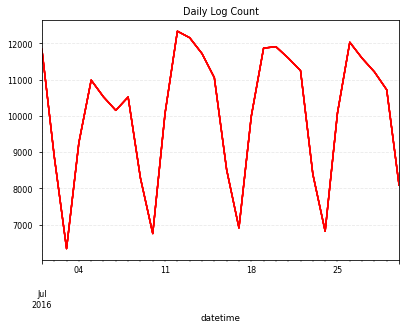

In [51]:
# daily log size
df.groupby('datetime').count().plot(c='r', legend=False)
plt.title('Daily Log Count')
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

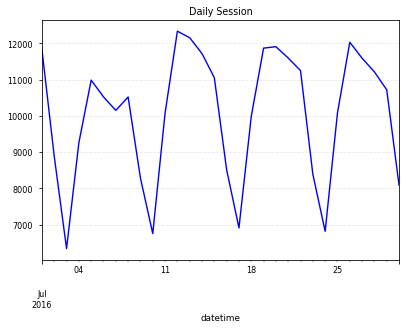

In [52]:
# daily session count (active 유저의 session)
df.groupby('datetime')['sessionid'].count().plot(c='b', legend=False)

plt.title('Daily Session')
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

- 앱 사용에 seasonality 존재
- 로그 수와 세션 수의 트렌드가 유사

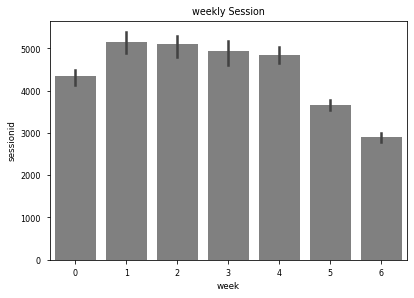

In [63]:
# weekly session count
# 0: Mon ~ 6: Sun
tmp = df.groupby('datetime')[['sessionid']].nunique().reset_index()
tmp['week'] = tmp['datetime'].apply(lambda x: x.weekday())

sns.barplot(data=tmp, x='week', y='sessionid', color='grey')
plt.title('weekly Session')
# plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

- 주말에 사용성이 감소하고, 평일에 높은 편
    - 화, 수요일에 가장 많이 사용하고, 월요일은 평일대비 비교적 낮은편
- 문서앱 특성상 직장인 or 학생이 주로 사용하는 것을 고려하면 당연한 결과

## 일별 Trend - 확장자, 위치, 액션, 스크린

# Clustering for Targeting